<a href="https://colab.research.google.com/github/hamidsadeghi68/Signature-Classification/blob/main/siamese_models_sign_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

KERAS **Signature Classification** on ICDAR 2011 Signature Dataset using **Siamese** CNN.

**Backbone models**: custom CNN and pretrained CNNs on ImageNet including Xception, InceptionV3, ResNet50, and MobileNetV2
  

# **Import Packages**

In [21]:
import os
import numpy as np
import pandas as pd

from PIL import Image
import matplotlib.pyplot as plt

from tensorflow import keras as keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Lambda, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from google.colab import drive

# **Parameters**

In [2]:
# -------------- Model ----------------
# backbone_model = 'custom_cnn'
## CNN models (pretrained on ImageNet)
# backbone_model = 'Xception'
# backbone_model = 'InceptionV3'
# backbone_model = 'ResNet50'
backbone_model = 'MobileNetV2'

# freeze convolutional layers:
freeze_conv_layers = True

# data:
img_size = 224        # image size

# training parameters:
batch_size = 64       # batch size
learning_rate = 1e-2  # learning rate
num_epoches = 5      # maximum number of epoches
steps_per_epoch = 100 # itration steps in each epoch

data_path = "./sign_data_models"

# **Dataset**

**Downloading Signature_Verification_Dataset from www.kaggle.com.**

You can manually download and use signature-verification-dataset.zip file from this url:

https://www.kaggle.com/datasets/robinreni/signature-verification-dataset/data

In [3]:
! pip install -q kaggle
from google.colab import files


if not os.path.exists("kaggle.json"):
  # Choose and upload Kaggle's API token file: kaggle.json
  # (in your kaggle profile, and create new token file and download kaggle.json)
  # Choose the kaggle.json file that you downloaded
  files.upload()

# Make directory named kaggle and copy kaggle.json file there.
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

# Change the permissions of the file.
! chmod 600 ~/.kaggle/kaggle.json

if not os.path.exists("signature-verification-dataset.zip"):
  # download dataset
  ! kaggle datasets download -d robinreni/signature-verification-dataset



Saving kaggle.json to kaggle.json
 99% 596M/601M [00:18<00:00, 39.6MB/s]
100% 601M/601M [00:18<00:00, 34.0MB/s]


unzip the dataset:

In [4]:
# unzip dataset
!unzip "signature-verification-dataset.zip"

Archive:  signature-verification-dataset.zip
  inflating: sign_data/sign_data/test/049/01_049.png  
  inflating: sign_data/sign_data/test/049/02_049.png  
  inflating: sign_data/sign_data/test/049/03_049.png  
  inflating: sign_data/sign_data/test/049/04_049.png  
  inflating: sign_data/sign_data/test/049/05_049.png  
  inflating: sign_data/sign_data/test/049/06_049.png  
  inflating: sign_data/sign_data/test/049/07_049.png  
  inflating: sign_data/sign_data/test/049/08_049.png  
  inflating: sign_data/sign_data/test/049/09_049.png  
  inflating: sign_data/sign_data/test/049/10_049.png  
  inflating: sign_data/sign_data/test/049/11_049.png  
  inflating: sign_data/sign_data/test/049/12_049.png  
  inflating: sign_data/sign_data/test/049_forg/01_0114049.PNG  
  inflating: sign_data/sign_data/test/049_forg/01_0206049.PNG  
  inflating: sign_data/sign_data/test/049_forg/01_0210049.PNG  
  inflating: sign_data/sign_data/test/049_forg/02_0114049.PNG  
  inflating: sign_data/sign_data/test/0

Image **preprocessing function** and **data loader** class:

In [5]:
def img_norm(x):
  # a simple image preprocessing function
  return (x - x.mean(axis=(0,1,2), keepdims=True)) / x.std(axis=(0,1,2), keepdims=True)

class DataLoader:
  #constructor
  def __init__(self, dataset, batch_size=32, img_size=112, dir='./'):
    self.dataset = dataset
    self.batch_size = batch_size
    self.dir = dir
    self.img_size = img_size
  #shuffler
  def shuffle(self):
    return self.dataset.sample(frac=1)
  #generator
  def datagen(self, repeat_flag=True):
    num_samples = len(self.dataset)
    while True:
        # shuffling the samples
        self.dataset = self.shuffle()
        for batch in range(1, num_samples, self.batch_size):
            image1_batch_samples = self.dir + "/" + self.dataset.iloc[:, 0][batch:batch + self.batch_size]
            image2_batch_samples = self.dir + "/" + self.dataset.iloc[:, 1][batch:batch + self.batch_size]
            label_batch_samples = self.dataset.iloc[:, 2][batch:batch + self.batch_size]
            Image1, Image2, Label = [], [], []
            for image1, image2, label in zip(image1_batch_samples, image2_batch_samples, label_batch_samples):
                # append them to Images directly
                image1_data = Image.open(image1)
                image2_data = Image.open(image2)
                # resizing the images
                image1_data = image1_data.resize((self.img_size, self.img_size))
                image2_data = image2_data.resize((self.img_size, self.img_size))
                # converting to array
                image1_data = img_to_array(image1_data)
                image2_data = img_to_array(image2_data)

                # image1_data = preprocess_input(image1_data)
                # image2_data = preprocess_input(image2_data)
                image1_data = img_norm(image1_data)
                image2_data = img_norm(image2_data)

                Image1.append(image1_data)
                Image2.append(image2_data)
                Label.append(label)
            # convert each list to numpy arrays to ensure that they get processed by fit function
            Image1 = np.asarray(Image1).astype(np.float32)
            Image2 = np.asarray(Image2).astype(np.float32)

            Label = np.asarray(Label).astype(np.float32)
            yield [Image1, Image2], Label
        if not repeat_flag:
          break

generators:

In [6]:
train_set_file = "./sign_data/train_data.csv"
test_set_file = "./sign_data/test_data.csv"

train_val_set = pd.read_csv(train_set_file)
train_set, val_set = train_test_split(train_val_set, test_size=0.2)
test_set = pd.read_csv(test_set_file)

train_gen= DataLoader(train_set, batch_size, img_size, "./sign_data/train/")
test_gen = DataLoader(test_set, batch_size, img_size, "./sign_data/test/")
val_gen= DataLoader(val_set, batch_size, img_size, "./sign_data/train/")

Test the train generator:

In [7]:
train_batch = next(train_gen.datagen())
print("Train batch images shape:", train_batch[0][0].shape, train_batch[0][1].shape)
print("Train batch labels shape:", train_batch[1].shape)

Train batch images shape: (64, 224, 224, 3) (64, 224, 224, 3)
Train batch labels shape: (64,)


# **Model**

Base Model:

In [8]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2


def custom_cnn():
  model = Sequential()
  model.add(Conv2D(4, (3,3), activation='relu', input_shape=input_shape))
  model.add(MaxPooling2D(2,2))
  model.add(Dropout(0.25))

  model.add(Conv2D(16, (3,3), activation='relu'))
  model.add(MaxPooling2D(5,5))
  model.add(Dropout(0.25))

  model.add(Flatten())
  model.add(Dense(256, activation='relu'))

  return model


def def_base_model(backbone='xception', freeze_conv_layers=True):
  print('backbone model: ' + backbone)
  if backbone == 'Xception':
    base_model = Xception(weights='imagenet', include_top=False)
  elif backbone == 'InceptionV3':
    base_model = InceptionV3(weights='imagenet', include_top=False)
  elif backbone == 'ResNet50':
    base_model = ResNet50(weights='imagenet', include_top=False)
  elif backbone == 'MobileNetV2':
    base_model = MobileNetV2(weights='imagenet', include_top=False)
  else:
    raise("unexpected backbone model. Backbone model can be choosen from: "
    "'Xception', 'InceptionV3', 'MobileNetV2', and 'ResNet50'")

  x = base_model.output
  x = GlobalAveragePooling2D()(x)
  x = Flatten()(x)
  x = Dense(128, activation='relu')(x)

  # first: train only the top layers (which were randomly initialized)
  # i.e. freeze all convolutional layers
  if freeze_conv_layers:
    print('freeze convolutional layers ...')
    for layer in base_model.layers:
        layer.trainable = False
  model = Model(inputs=base_model.input, outputs=x)
  return model

Siamese Model:

In [9]:
def siamese_model(input_shape, backbone_model='custom_cnn',
                  freeze_conv_layers=True):
    input1 = Input(input_shape)
    input2 = Input(input_shape)

    if backbone_model=='custom_cnn':
      base_model = custom_cnn()
    else:
      base_model = def_base_model(backbone_model, freeze_conv_layers)

    # Call the model with the inputs:
    embedding1 = base_model(input1)
    embedding2 = base_model(input2)

    # custom loss layer:
    loss_layer = Lambda(lambda tensors: K.abs(tensors[0] - tensors[1]))
    manhattan_distance = loss_layer([embedding1, embedding2])

    # add a dense layer for 2-class classification (genuine and fraud):
    output = Dense(1, activation='sigmoid')(manhattan_distance)

    network = Model(inputs=[input1, input2], outputs=output)
    return network

In [10]:
model = siamese_model((img_size, img_size, 3), backbone_model, freeze_conv_layers)
model.summary()

backbone model: MobileNetV2
9406464/9406464 [==============================] - 1s 0us/step
freeze convolutional layers ...
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 model (Functional)          (None, 128)                  2421952   ['input_1[0][0]',             
                                                                     'input_2[0][0]']             
                                                                    

# **Train & Test**

Define f1_score function to use during training:

In [11]:
def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

Compile the model:

In [12]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=learning_rate,
    decay_steps=5*steps_per_epoch,
    decay_rate=0.5)

optimizer = Adam(learning_rate=lr_schedule, weight_decay=0.2)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=['accuracy', f1_score])

In [13]:
early_stopper =  EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1)
custom_callback = [early_stopper]

Train:

In [14]:
print("Training!")
checkpoint_filepath = data_path + '/best_model.hdf5'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

history = model.fit(
    train_gen.datagen(),
    verbose=1,
    steps_per_epoch=steps_per_epoch,  # set appropriate steps_per_epoch
    epochs=num_epoches,
    validation_data=val_gen.datagen(),
    validation_steps=1,  # set appropriate validation_steps
    callbacks=[model_checkpoint_callback]
)

Training!
Epoch 1/5
100/100 [==============================] - ETA: 0s - loss: 0.3199 - accuracy: 0.8631 - f1_score: 0.8480

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


100/100 [==============================] - 111s 892ms/step - loss: 0.3199 - accuracy: 0.8631 - f1_score: 0.8480 - val_loss: 0.1596 - val_accuracy: 0.9375 - val_f1_score: 0.9375
Epoch 2/5
100/100 [==============================] - 86s 867ms/step - loss: 0.0867 - accuracy: 0.9709 - f1_score: 0.9671 - val_loss: 0.0763 - val_accuracy: 0.9688 - val_f1_score: 0.9643
Epoch 3/5
100/100 [==============================] - 86s 870ms/step - loss: 0.0465 - accuracy: 0.9883 - f1_score: 0.9870 - val_loss: 0.0413 - val_accuracy: 0.9844 - val_f1_score: 0.9818
Epoch 4/5
100/100 [==============================] - 86s 871ms/step - loss: 0.0193 - accuracy: 0.9978 - f1_score: 0.9974 - val_loss: 0.0414 - val_accuracy: 0.9844 - val_f1_score: 0.9831
Epoch 5/5
100/100 [==============================] - 87s 879ms/step - loss: 0.0115 - accuracy: 0.9991 - f1_score: 0.9990 - val_loss: 0.0152 - val_accuracy: 1.0000 - val_f1_score: 1.0000


Plot traning curves:

dict_keys(['loss', 'accuracy', 'f1_score', 'val_loss', 'val_accuracy', 'val_f1_score'])


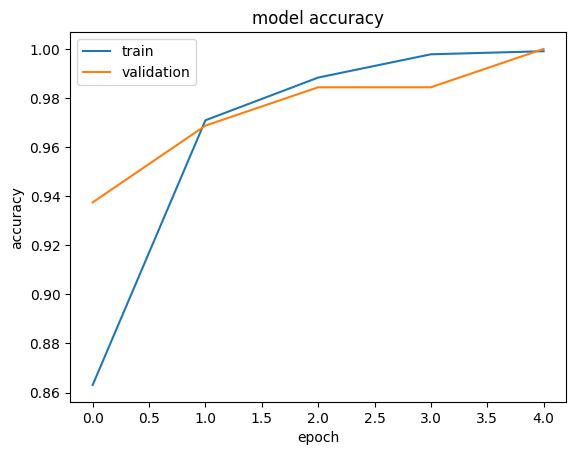

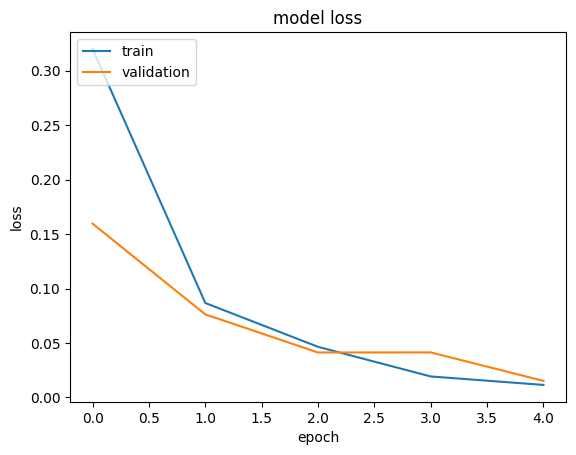

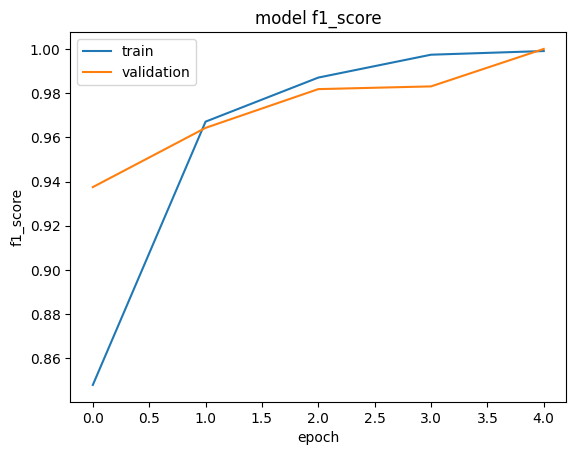

In [15]:
# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for f1_score
plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])
plt.title('model f1_score')
plt.ylabel('f1_score')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

**Save the trained model**

In [16]:
keras.saving.save_model(model, backbone_model + '.h5', overwrite=True)

<ipython-input-16-910306078cc1>:1: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  keras.saving.save_model(model, backbone_model + '.h5', overwrite=True)


**Test**

In [17]:
# loaded_model = keras.saving.load_model(backbone_model + '.h5')
loaded_model = keras.saving.load_model(checkpoint_filepath,custom_objects={"f1_score": f1_score})
result = loaded_model.evaluate(test_gen.datagen(repeat_flag=False), batch_size=None,
                               verbose=1, sample_weight=None, steps=None,
                               callbacks=None, max_queue_size=10, workers=1,
                               use_multiprocessing=False, return_dict=False)

90/90 [==============================] - 87s 953ms/step - loss: 0.0122 - accuracy: 0.9981 - f1_score: 0.9981


confusion matrix for 2 classes:

In [18]:
y_gt = []
y_pr = []
for data in test_gen.datagen(repeat_flag=False):
  labels = data[1]
  predictions = loaded_model.predict(data[0], verbose=0)
  for i, label in enumerate(labels):
    y_gt.append(label)
    y_pr.append(predictions[i])

In [19]:
y_pr = np.round(y_pr)
cm = confusion_matrix(y_gt, y_pr, normalize='true')
print(cm)

[[9.99278499e-01 7.21500722e-04]
 [3.02622730e-03 9.96973773e-01]]


Calculate classification metrics on test data:

In [20]:
from sklearn.metrics import classification_report
print(classification_report(y_gt, y_pr))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2772
         1.0       1.00      1.00      1.00      2974

    accuracy                           1.00      5746
   macro avg       1.00      1.00      1.00      5746
weighted avg       1.00      1.00      1.00      5746

